<a href="https://colab.research.google.com/github/larasauser/2024_MLEES/blob/main/Project/project_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**# Machine learning Project - Sauser Lara**
## *Filling gaps in NDVI images using CNN*
The goal of this notebook is to build a CNN model with a simple U-net architecture in order to fill gaps in NDVI images. Here are the steps I followed:


1.   Data processing


*   Loading the dataset
*   Imputing the images with the Median strategy
*   Split the images into smaller sub-images of 32x32 pixels
*   Add holes in the sub-images
*   Separate into train, validation and test set.
*   Pair the ground truth images with their respective hole version
*   Create X_train,y_train, X_val,y_val


2.   Model building


*   Create loss function
*   Build the architecture
*   Tune Hyperparameters
*   Train the model with the optimal parameters
*   Evaluate



3.   Test the performance on the test set


*   Load the images
*   Pair the ground truth images with their respective hole version
*   Load the model
*   Make predictions
*   Visualise the results
*   Evaluate the model (Distribution, R2, RMSE, MAE)

4.   Apply the model to another area (Val d'Hérens)

















### 0. Dependancies, drive mount

Please run these cells before going further.

In [ ]:
# System-specific utilities
!apt-get install graphviz
!pip install rasterio
!pip install keras-tuner
# Dependencies
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras.models import load_model

import tensorflow as tf
import keras_tuner as kt
from keras_tuner import HyperParameters

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pydot

import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

from tqdm import tqdm
import rasterio

import random
import os
import shutil
import json
from google.colab import drive


In [ ]:
#Mount Google Drive
drive.mount('/content/drive')

### 1. Data processing





First, let's get access to the image folder in Google Drive.

In [ ]:
folder_path = '/content/drive/My Drive/NDVI_images/'

Let's visualise some of our original images to see what we are working with.

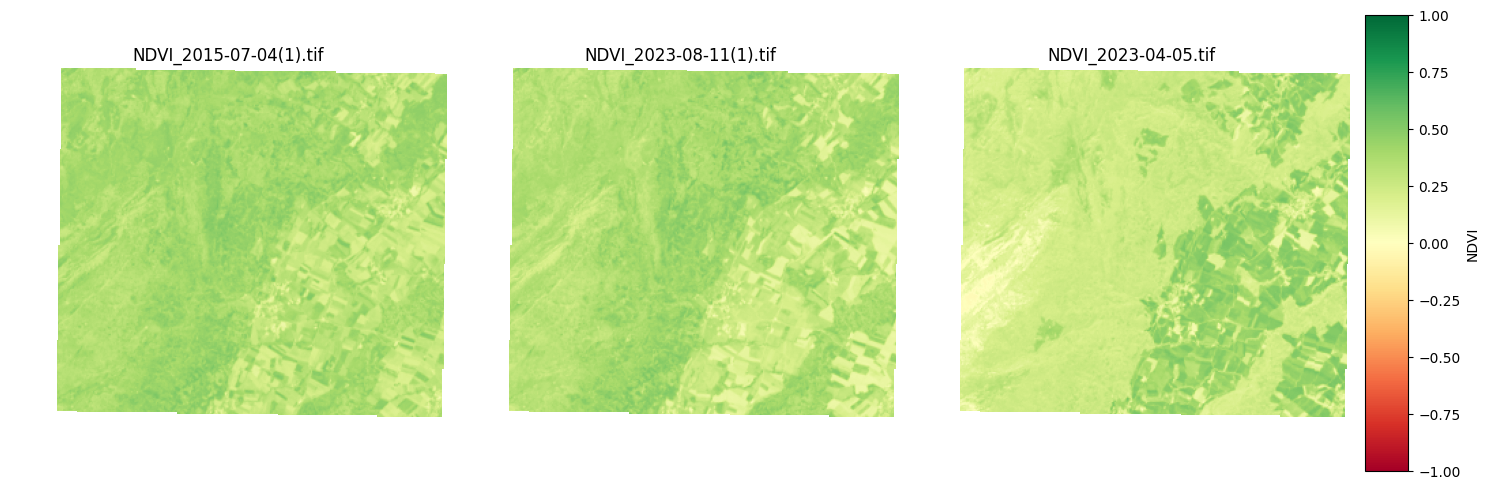

In [ ]:
# Get a list of files in the directory
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

# Indexes to visualise
selected_indices = [10, 45, 90 ]

# Ensure indices are within range
selected_files = [tif_files[i] for i in selected_indices if i < len(tif_files)]

# Set up layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(selected_files) + 1, width_ratios=[1] * len(selected_files) + [0.1])  # Extra column for the colorbar

axes = [fig.add_subplot(gs[0, i]) for i in range(len(selected_files))]  # Subplots for images
cbar_ax = fig.add_subplot(gs[0, -1])  # Separate subplot for the colorbar

for i, file_name in enumerate(selected_files):
    file_path = os.path.join(folder_path, file_name)

    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        ndvi_data = src.read(1)  # Read the first band (NDVI values)
        ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)  # Handle NaN values

    # Plot the NDVI data in the subplot
    im = axes[i].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(file_name)
    axes[i].axis('off')

# Add the shared colorbar in the dedicated axis
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('NDVI')

# Adjust layout
plt.tight_layout()
plt.show()

Images contains NaNs values. Thus, we need to fill them in.
We use a SimpleImputer based on the median strategy.

In [ ]:
# Create folder with imputed images
output_folder = os.path.join(folder_path, "imputed")
os.makedirs(output_folder, exist_ok=True)

# Imputation function
def impute_ndvi_image(image_path, output_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)
        meta = src.meta

    # Mask NaN
    nan_mask = np.isnan(image)

    # Imputation of NaN with median
    imputer = SimpleImputer(strategy='median')
    image_imputed = imputer.fit_transform(image)

    # Save the image
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(image_imputed, 1)

# Loop over every file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, filename)
        impute_ndvi_image(input_path, output_path)


The next chunk is used to verify that the images were correctly imputed and that no NaN remains.

In [ ]:
folder_path = '/content/drive/My Drive/NDVI_images/imputed'

def check_for_nan(image_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)
    if np.isnan(image).any():
        print(f"Nan remaining in {image_path}")
    else:
        print(f"No Nan in {image_path}")

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        file_path = os.path.join(folder_path, filename)
        check_for_nan(file_path)


To have more images and to reduce computational cost, we decide to devide them into sub-images of 32x32 pixels.

In [ ]:
def split_image(image_path, output_folder, sub_image_size=(32, 32)):
    # Open image
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Image count
    count = 0

    # Division
    for i in range(0, img_width, sub_image_size[0]):
        for j in range(0, img_height, sub_image_size[1]):
            # Cutting box
            box = (i, j, i + sub_image_size[0], j + sub_image_size[1])
            # Cutting
            sub_image = img.crop(box)
            # Verification (size)
            if sub_image.size[0] > 0 and sub_image.size[1] > 0:
                # Saving
                sub_image.save(os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_path))[0]}_sub_image_{count}.tif"))
                count += 1
    print(count)

def process_all_images(input_folder, output_folder):
    # List all tif file in input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.tif'):
            image_path = os.path.join(input_folder, filename)
            print(f"Image in treatment : {filename}")
            split_image(image_path, output_folder)


In [ ]:
#Split our images
folder_path = '/content/drive/My Drive/NDVI_images/imputed'
output_folder = '/content/drive/My Drive/NDVI_images/split'
process_all_images(folder_path, output_folder)

We now have 8184 images to use for our model.

#### 1.1 Split the dataset into train, validation and test set

In [ ]:
# Define the source directory and the new directories for train, validation, and test sets
source_dir = '/content/drive/My Drive/NDVI_images/split'
train_dir = '/content/drive/My Drive/NDVI_images/train'
val_dir = '/content/drive/My Drive/NDVI_images/validation'
test_dir = '/content/drive/My Drive/NDVI_images/test'

In [ ]:
# Create the new directories if they don't exist
for dir in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [ ]:
# Get all image files from the source directory
all_images = [f for f in os.listdir(source_dir) if f.endswith(('.tif'))]

In [ ]:
# Shuffle the list of images
random.shuffle(all_images)

In [ ]:
# Calculate the number of images for each set
total_images = len(all_images)
train_split = int(0.7 * total_images)
val_split = int(0.2 * total_images)

In [ ]:
# Split the images into train, validation, and test sets
train_images = all_images[:train_split]
val_images = all_images[train_split:train_split+val_split]
test_images = all_images[train_split+val_split:]

In [ ]:
# Function to copy images to their respective directories
def copy_images(image_list, destination):
    for image in image_list:
        src = os.path.join(source_dir, image)
        dst = os.path.join(destination, image)
        shutil.copy(src, dst)


In [ ]:
# Copy the images to their respective directories
copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

In [ ]:
print(f"Total images: {total_images}")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

Total images: 8184
Training images: 5728
Validation images: 1636
Test images: 820


#### 1.2 Create fake holes in images for training set

We decided to simulate missing data by adding holes in the images by deleting pixels (replacing values with NaNs). Images will contains 4 holes randomly placed of a random size between 1 and 12 pixels wide. In order to keep the original images as ground truth, copy of the files are done before adding holes to them. To make pairing easier later, same file name are kept, but they are placed in a dedicated folder.

In [ ]:
# Define the paths
train_dir = '/content/drive/My Drive/NDVI_images/train'
output_dir = os.path.join(train_dir, 'train_with_holes')

In [ ]:
def add_fake_holes(image, num_holes=4, max_hole_size=12):
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to nan)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = np.nan

    return image_with_holes


In [ ]:
def process_and_add_fake_holes(train_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(train_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(train_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band
            except Exception as e:
                print(f"Failed to process {filename}: {e}")


In [ ]:
process_and_add_fake_holes(train_dir, output_dir)

#### 1.3 Create holes in image of the validation set

The same steps are repeated for the validation set.

In [ ]:
# Define the paths
val_dir = '/content/drive/My Drive/NDVI_images/validation'
output_dir = os.path.join(val_dir, 'val_with_holes')

In [ ]:
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def add_fake_holes(image, num_holes=4, max_hole_size=12):
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to nan)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = np.nan

    return image_with_holes


In [ ]:
def process_and_add_fake_holes(val_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(val_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(val_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band
            except Exception as e:
                print(f"Failed to process {filename}: {e}")


In [ ]:
process_and_add_fake_holes(val_dir, output_dir)

We can now see with the code below how our images look before continuing.

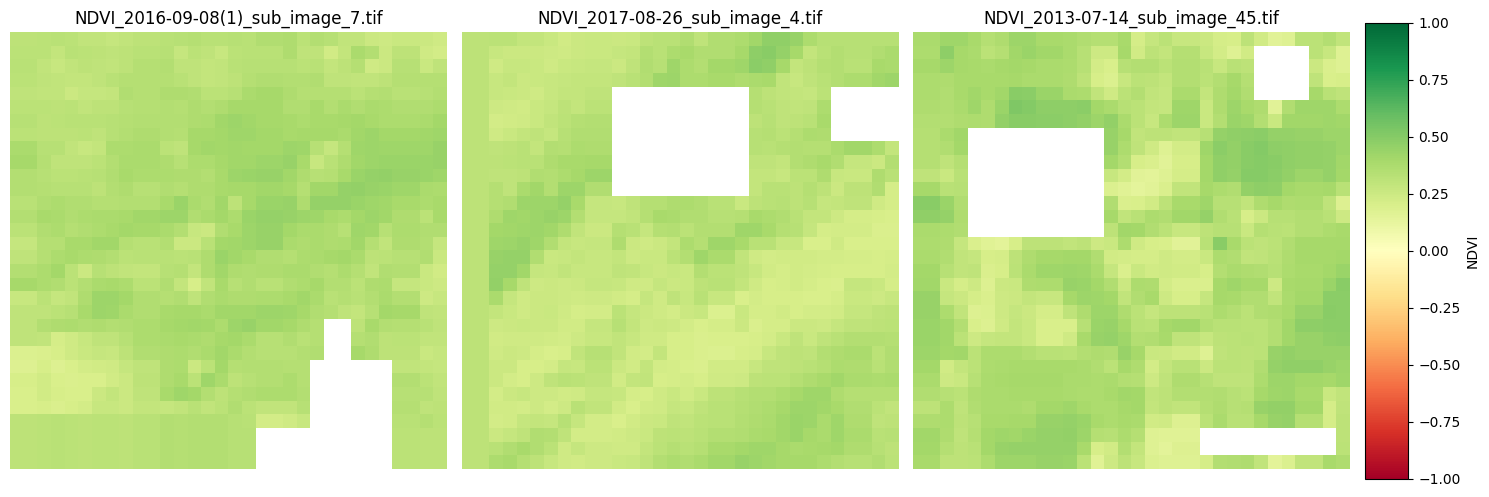

In [ ]:
# Get a list of files in the directory
tif_files = [f for f in os.listdir(train_with_holes_dir) if f.endswith('.tif')]

# Indexes
selected_indices = [0, 50, 1000 ]

# Ensure indices are within range
selected_files = [tif_files[i] for i in selected_indices if i < len(tif_files)]

# Set up layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(selected_files) + 1, width_ratios=[1] * len(selected_files) + [0.1])  # Extra column for the colorbar

axes = [fig.add_subplot(gs[0, i]) for i in range(len(selected_files))]  # Subplots for images
cbar_ax = fig.add_subplot(gs[0, -1])  # Separate subplot for the colorbar

for i, file_name in enumerate(selected_files):
    file_path = os.path.join(train_with_holes_dir, file_name)

    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        ndvi_data = src.read(1)  # Read the first band (NDVI values)
        ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)  # Handle NoData values

    # Plot the NDVI data in the subplot
    im = axes[i].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(file_name)
    axes[i].axis('off')

# Add the shared colorbar in the dedicated axis
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('NDVI')

# Adjust layout
plt.tight_layout()
plt.show()

Great ! We can see that random holes are effectively introduced into the images. We can proceed.

#### 1.4 Pairing the complete images with the images with holes (train and validation)

Images are paired via file names.

In [ ]:
#Load the training data
train_dir = '/content/drive/My Drive/NDVI_images/train'
train_with_holes_dir = '/content/drive/My Drive/NDVI_images/train/train_with_holes'

val_dir = '/content/drive/My Drive/NDVI_images/validation'
val_with_holes_dir = '/content/drive/My Drive/NDVI_images/validation/val_with_holes'

In [ ]:
def load_and_pair_images(input_dir, target_dir):
    image_pairs = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(input_dir, filename)
            target_path = os.path.join(target_dir, filename)

            # Load images
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            target_img = cv2.imread(target_path, cv2.IMREAD_UNCHANGED)

            if input_img is not None and target_img is not None:
                image_pairs.append((input_img, target_img))
            else:
                print(f"Failed to load {filename}. Skipping...")
    return image_pairs

In [ ]:
# Load and pair the training data
train_data = load_and_pair_images(train_dir, train_with_holes_dir)

# Load and pair validation data
val_data = load_and_pair_images(val_dir, val_with_holes_dir)

#### 1.5 Masking

For the code to work, the images can't have NaNs values. But we just introduced some. Therefore, we want to change that. We want a value outside of the range of NDVI values so that they won't interfere. We chose a value of 10.

In [ ]:
MASK_VALUE = 10  # Set a value to replace NaN

In [ ]:
# Convert to numpy arrays
X_train = np.array([pair[0] for pair in train_data])
y_train = np.array([pair[1] for pair in train_data])

In [ ]:
X_val = np.array([pair[0] for pair in val_data])
y_val = np.array([pair[1] for pair in val_data])

In [ ]:
# Replace NaN with MASK_VALUE in training and validation datasets
X_train = np.nan_to_num(X_train, nan=MASK_VALUE)
y_train = np.nan_to_num(y_train, nan=MASK_VALUE)

X_val = np.nan_to_num(X_val, nan=MASK_VALUE)
y_val = np.nan_to_num(y_val, nan=MASK_VALUE)

In [ ]:
print("X_train min, max:", np.min(X_train), np.max(X_train))
print("y_train min, max:", np.min(y_train), np.max(y_train))
print("X_val min, max:", np.min(X_val), np.max(X_val))
print("y_val min, max:", np.min(y_val), np.max(y_val))

X_train min, max: -0.12699474 0.9998047
y_train min, max: -0.12699474 10.0
X_val min, max: -0.1493801 0.9994043
y_val min, max: -0.1493801 10.0


We can see that the ranges in the original images are within -1 and 1. The image with holes goes up to 10, because of the Mask value.

### 2. Model Building (CNN)

It's time to build the CNN with the U-Net architecture.

#### 2.1 Loss function

Because of the mask_value, we need to change the way the loss function is calculated, to avoid the value 10. Here is the new loss function.

In [ ]:
# Define the custom loss function
def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, MASK_VALUE), tf.float32)
    loss = tf.reduce_sum(mask * tf.abs(y_true - y_pred)) / tf.reduce_sum(mask)
    return loss

#### 2.2 Building the CNN

The goal is to build a simple CNN with a U-Net architecture that is able to produce output between -1 and 1. To do so, we need a Encoder, a decoder and a skip connexion in between. The activation functions will be ReLU for its efficiency and Tanh in the output layer to retrieve the -1 to 1 range.
To mitigate potential overfitting, we added dropout layers.

In [ ]:
def build_unet_model(input_shape):
    """Build a simple U-Net model."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = layers.Dropout(0.2)(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Bottleneck
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = layers.Dropout(0.3)(conv2)

    # Decoder
    up3 = layers.UpSampling2D((2, 2))(conv2)
    concat3 = layers.Concatenate()([up3, conv1])
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

    # Output layer
    output = layers.Conv2D(1, (1, 1), activation='tanh', padding='same')(conv3)

    # Compile model
    model = models.Model(inputs, output)
    model.compile(optimizer='adam', loss=masked_mae, metrics=['mae'])

    return model

#### 2.3 Hyperparameter optimization

We decided to optimize the learning rate using randomsearch from Keras Tuner

In [ ]:
def model_builder(hp):
    model = build_unet_model((32, 32, 1))

    # Tune the learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    ), loss=masked_mae, metrics=['mae'])

    return model

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,  # Limit to 10 trials for computational cost
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='ndvi_inpainting',
)

In [ ]:
# Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=4, validation_data=(X_val, y_val),
            batch_size=32)

Trial 10 Complete [00h 20m 38s]
val_loss: 0.013730124570429325

Best val_loss So Far: 0.002393252681940794
Total elapsed time: 03h 10m 29s


In [ ]:
# Get the best Hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best learning rate: ", best_hp['learning_rate'])

Best learning rate:  0.0009120605909040556


Since this step takes a long time, we decide to save the value for later, so that we don't need to re-run this step everytime we deconnect from the server.

In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Save the hyperparameters to a JSON file
hyperparameters_path = '/content/drive/My Drive/NDVI_images/best_hyperparameters_3.json'

with open(hyperparameters_path, 'w') as f:
    json.dump(best_hp.values, f, indent=4)

print(f"Best hyperparameters saved to {hyperparameters_path}")


Best hyperparameters saved to /content/drive/My Drive/NDVI_images/best_hyperparameters_3.json


#### 2.4 Train the model with the best Hyperparameters

In [ ]:
hyperparameters_path = '/content/drive/My Drive/NDVI_images/best_hyperparameters_3.json'
# Load the hyperparameters from the JSON file
with open(hyperparameters_path, 'r') as f:
    loaded_hyperparameters = json.load(f)

print("Loaded hyperparameters:", loaded_hyperparameters)

Loaded hyperparameters: {'learning_rate': 0.0009120605909040556}


In [ ]:
# Rebuild the U-Net model
input_shape = (32, 32, 1)
best_model = build_unet_model(input_shape)

# Compile the model with the loaded learning rate
best_model.compile(
    optimizer=Adam(learning_rate=loaded_hyperparameters['learning_rate']),
    loss=masked_mae,
    metrics=['mae']
)

In [ ]:
# Configure EarlyStopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
# Set up callbacks to monitor progress
history = best_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32,callbacks=[early_stopping])


Epoch 1/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - loss: 0.0420 - mae: 1.0072 - val_loss: 0.0057 - val_mae: 0.9725
Epoch 2/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - loss: 0.0088 - mae: 0.9770 - val_loss: 0.0071 - val_mae: 0.9740
Epoch 3/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - loss: 0.0071 - mae: 0.9711 - val_loss: 0.0048 - val_mae: 0.9717
Epoch 4/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - loss: 0.0089 - mae: 0.9732 - val_loss: 0.0036 - val_mae: 0.9703
Epoch 5/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - loss: 0.0056 - mae: 0.9580 - val_loss: 0.0080 - val_mae: 0.9749
Epoch 6/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - loss: 0.0054 - mae: 0.9623 - val_loss: 0.0027 - val_mae: 0.9694
Epoch 7/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - loss: 0.0055 - mae: 0.9609 - val_loss: 0.0033 - val_mae: 0.9699
Epoch 8/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - loss: 0.0048 - mae: 0.9644 - val_loss: 0.0040 - val_mae: 0.9708
Epoch 9/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/

In [ ]:
# Save the model
best_model.save('/content/drive/My Drive/NDVI_images/best_unet_model_4.keras')

#### 2.5 Evaluation of Loss and MAE

In [ ]:
def plot_history(history, save_path):
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE (Mean Absolute Error)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # Save the plots to file
    plt.savefig(save_path)
    plt.close()

In [ ]:
plot_history(history, '/content/drive/My Drive/NDVI_images/training_history_4.png')

### 3. Verification on the Test set

Now that the model is trained, it's time to see how it perfoms on the test set previously created.

##### 3.1 Create fake holes in images for test set

In [ ]:
# Define the paths
test_dir = '/content/drive/My Drive/NDVI_images/test'
output_dir = os.path.join(test_dir, 'test_with_holes')

In [ ]:
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def add_fake_holes(image, num_holes=4, max_hole_size=12):
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to nan)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = np.nan

    return image_with_holes


In [ ]:
def process_and_add_fake_holes(test_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(test_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(test_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band
            except Exception as e:
                print(f"Failed to process {filename}: {e}")


In [ ]:
process_and_add_fake_holes(test_dir, output_dir)

##### 3.2 Pairing the complete images with the images with holes (test)

In [ ]:
#Load the test data
test_dir = '/content/drive/My Drive/NDVI_images/test'
test_with_holes_dir = '/content/drive/My Drive/NDVI_images/test/test_with_holes'

In [ ]:
def load_and_pair_images(input_dir, target_dir):
    image_pairs = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(input_dir, filename)
            target_path = os.path.join(target_dir, filename)

            # Load images
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            target_img = cv2.imread(target_path, cv2.IMREAD_UNCHANGED)

            if input_img is not None and target_img is not None:
                image_pairs.append((input_img, target_img))
            else:
                print(f"Failed to load {filename}. Skipping...")
    return image_pairs

In [ ]:
# Load and pair the training data
test_data = load_and_pair_images(test_dir, test_with_holes_dir)

##### 3.3 Data processing and masking

In [ ]:
MASK_VALUE = 10  # Set a value to replace NaN

In [ ]:
# Convert to numpy arrays
X_test = np.array([pair[0] for pair in test_data])
y_test = np.array([pair[1] for pair in test_data])

In [ ]:
# Replace NaN with MASK_VALUE in training and validation datasets
X_test = np.nan_to_num(X_test, nan=MASK_VALUE)
y_test = np.nan_to_num(y_test, nan=MASK_VALUE)

In [ ]:
print("X_test min, max:", np.min(X_test), np.max(X_test))
print("y_test min, max:", np.min(y_test), np.max(y_test))

X_test min, max: -0.09456226 0.9920558
y_test min, max: -0.09456226 10.0


##### 3.4 Apply CNN

In [ ]:
# Define the custom loss function
def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, MASK_VALUE), tf.float32)
    loss = tf.reduce_sum(mask * tf.abs(y_true - y_pred)) / tf.reduce_sum(mask)
    return loss

In [ ]:
# Load the saved model
model_path = '/content/drive/My Drive/NDVI_images/best_unet_model_4.keras'
best_model = load_model(model_path, custom_objects={'masked_mae': masked_mae})

In [ ]:
# Generate predictions
y_pred = best_model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 423ms/step


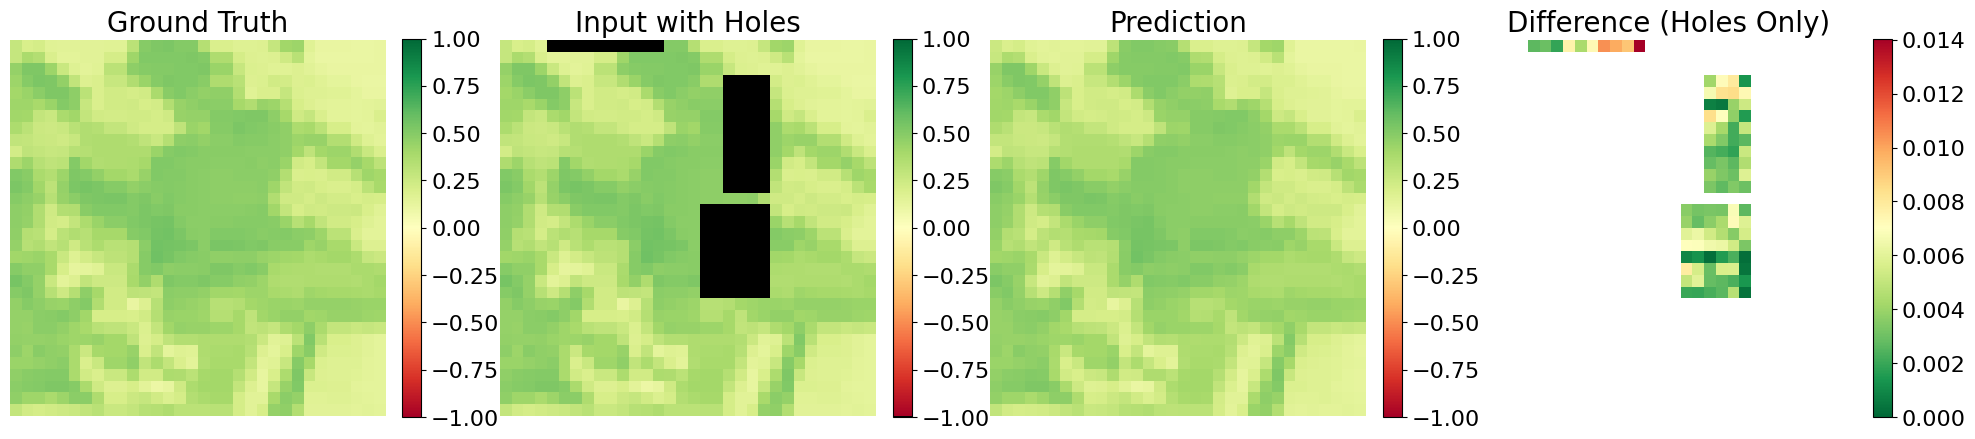

In [ ]:
# Creation of a custom colormap for holes (special values = 10)
cmap = plt.cm.RdYlGn  # Base colormap
cmap_colors = cmap(np.linspace(0, 1, 256))
cmap_colors[0] = [0, 0, 0, 1]  # Black for holes (values of 10)
custom_cmap = ListedColormap(cmap_colors)

# Custom normalization
class CustomNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, special_value=None, **kwargs):
        super().__init__(vmin=vmin, vmax=vmax, **kwargs)
        self.special_value = special_value

    def __call__(self, value, clip=None):
        # Treat holes as a special value
        result = super().__call__(value, clip)
        result = np.ma.masked_where(value == self.special_value, result)
        result = np.ma.filled(result, 0)  # Map holes (values of 10) to the first color (black)
        return result

# Apply custom normalization to handle holes
norm = CustomNormalize(vmin=-1, vmax=1, special_value=10)

# Calculate the difference between the predicted image and the original image
difference = np.abs(X_test - y_pred.squeeze())  # Absolute difference

# Create a mask to display only the holes
mask_holes = (y_test == 10)  # Mask of holed pixels
difference_holes_only = np.where(mask_holes, difference, np.nan)  # Mask other pixels

# Visualization of results
idx = 432  # Index to visualize a specific sample

plt.figure(figsize=(20, 5))

# Ground truth
plt.subplot(1, 4, 1)
plt.title("Ground Truth", fontsize=20)  # Increase font size
img1 = plt.imshow(X_test[idx, :, :], cmap='RdYlGn', norm=norm)
plt.axis('off')
cbar1 = plt.colorbar(img1, fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Input image with holes
plt.subplot(1, 4, 2)
plt.title("Input with Holes", fontsize=20)  # Increase font size
img2 = plt.imshow(y_test[idx, :, :], cmap=custom_cmap, norm=norm)
plt.axis('off')
cbar2 = plt.colorbar(img2, fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Predictions
plt.subplot(1, 4, 3)
plt.title("Prediction", fontsize=20)  # Increase font size
img3 = plt.imshow(y_pred[idx, :, :], cmap='RdYlGn', norm=norm)
plt.axis('off')
cbar3 = plt.colorbar(img3, fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Difference only in the holes
plt.subplot(1, 4, 4)
plt.title("Difference (Holes Only)", fontsize=20)  # Increase font size
img4 = plt.imshow(difference_holes_only[idx, :, :], cmap='RdYlGn_r', vmin=0)  # Colormap for differences
plt.axis('off')
cbar4 = plt.colorbar(img4, fraction=0.046, pad=0.04)
cbar4.ax.tick_params(labelsize=16)  # Increase colorbar font size

plt.tight_layout()
plt.show()

##### 3.5 Evaluate the model

In [ ]:
MASK_VALUE = 10  # Replace with your actual mask value

# Flatten the arrays to simplify processing
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Step 1: Create a mask for valid pixels
valid_mask = y_test_flat != MASK_VALUE

# Step 2: Extract valid pixels from ground truth and predictions
y_test_valid = y_test_flat[valid_mask]
y_pred_valid = y_pred_flat[valid_mask]

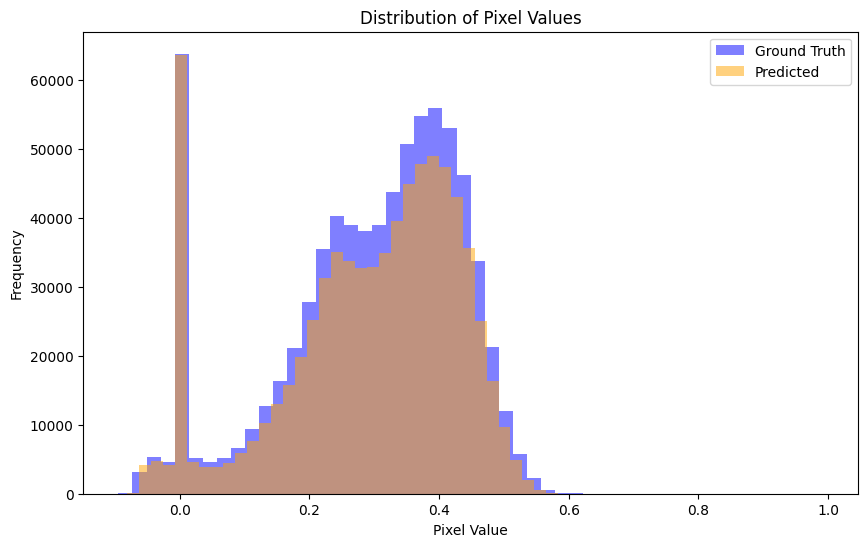

<ipython-input-47-09dce2b95e20>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test_valid, label='Ground Truth', color='blue', shade=True)
<ipython-input-47-09dce2b95e20>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_valid, label='Predicted', color='orange', shade=True)


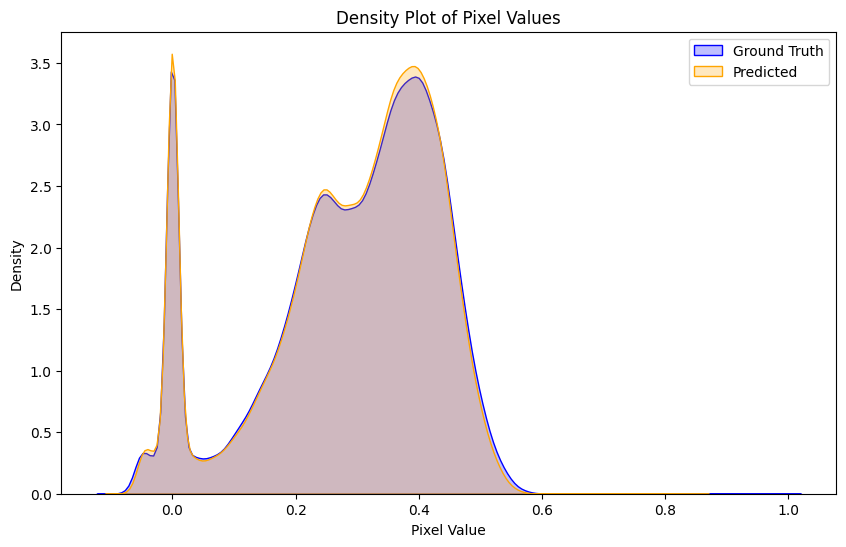

In [ ]:
# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(y_test_valid, bins=50, alpha=0.5, label='Ground Truth', color='blue')
plt.hist(y_pred_valid, bins=50, alpha=0.5, label='Predicted', color='orange')
plt.title('Distribution of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Density plot (smoother)
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test_valid, label='Ground Truth', color='blue', shade=True)
sns.kdeplot(y_pred_valid, label='Predicted', color='orange', shade=True)
plt.title('Density Plot of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
#Evaluation metrics
mae = np.mean(np.abs(y_test_valid - y_pred_valid))
print(f"Mean Absolute Error (MAE): {mae}")
rmse = np.sqrt(np.mean((y_test_valid - y_pred_valid) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse}")
mape = np.mean(np.abs((y_test_valid - y_pred_valid) / y_test_valid)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
correlation = np.corrcoef(y_test_valid, y_pred_valid)[0, 1]
r_squared = correlation ** 2
print(f"R² (Coefficient of Determination): {r_squared}")

Mean Absolute Error (MAE): 0.002575413091108203
Root Mean Square Error (RMSE): 0.0037470925599336624
Mean Absolute Percentage Error (MAPE): inf%
R² (Coefficient of Determination): 0.9994483947201547


<ipython-input-48-f0cdbcfc372e>:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_valid - y_pred_valid) / y_test_valid)) * 100


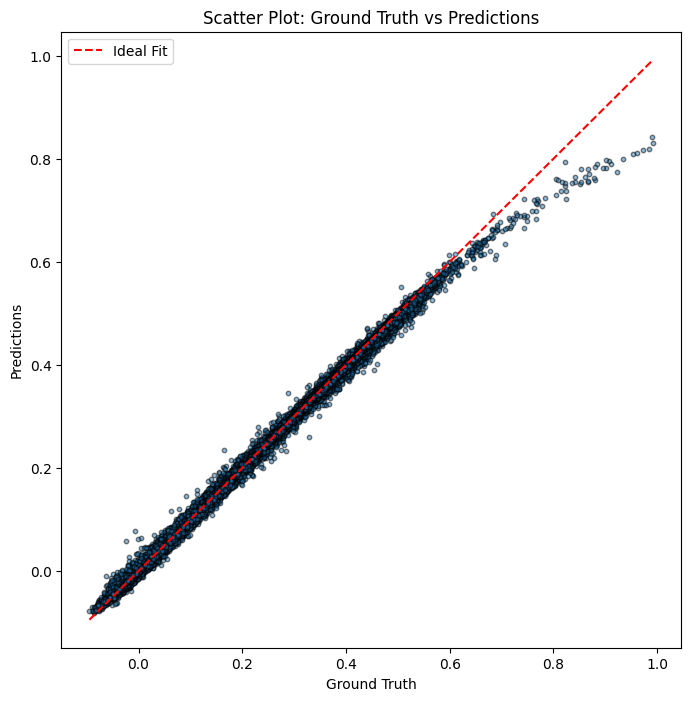

In [ ]:
#Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_valid, y_pred_valid, alpha=0.5, edgecolor='k', s=10)
plt.plot([y_test_valid.min(), y_test_valid.max()],
         [y_test_valid.min(), y_test_valid.max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title('Scatter Plot: Ground Truth vs Predictions')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.legend()
plt.show()

### 4. Test on another region (Val d'Hérens)

If you want to start from the original images, run the whole section. If you only want to predict images based on the images we already prepared (and save time) , please start at the load and pair part.

In [ ]:
folder_path = '/content/drive/My Drive/NDVI_herens/'

In [ ]:
# Create a folder to save the corrected images
output_folder = os.path.join(folder_path, "imputed")
os.makedirs(output_folder, exist_ok=True)

# Function to impute NaN values
def impute_ndvi_image(image_path, output_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)  # Read only the first band
        meta = src.meta  # Metadata for saving

    # Mask for NaN values
    nan_mask = np.isnan(image)

    # Imputation of NaN values with the median
    imputer = SimpleImputer(strategy='median')
    image_imputed = imputer.fit_transform(image)

    # Save the corrected image
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(image_imputed, 1)

# Loop through all images in the folder and apply imputation
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, filename)
        impute_ndvi_image(input_path, output_path)

In [ ]:
folder_path = '/content/drive/My Drive/NDVI_herens/imputed'

def check_for_nan(image_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)

    # Vérifier s'il reste des NaN
    if np.isnan(image).any():
        print(f"Nan remaining in {image_path}")
    else:
        print(f"No nan in {image_path}")

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        file_path = os.path.join(folder_path, filename)
        check_for_nan(file_path)

In [ ]:
def split_image(image_path, output_folder, sub_image_size=(32, 32)):
    # Open image
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Image count
    count = 0

    # Division
    for i in range(0, img_width, sub_image_size[0]):
        for j in range(0, img_height, sub_image_size[1]):
            # Cutting box
            box = (i, j, i + sub_image_size[0], j + sub_image_size[1])
            # Cutting
            sub_image = img.crop(box)
            # Verification (size)
            if sub_image.size[0] > 0 and sub_image.size[1] > 0:
                # Saving
                sub_image.save(os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_path))[0]}_sub_image_{count}.tif"))
                count += 1
    print(count)

def process_all_images(input_folder, output_folder):
    # List all tif file in input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.tif'):
            image_path = os.path.join(input_folder, filename)
            print(f"Image in treatment : {filename}")
            split_image(image_path, output_folder)


In [ ]:
#Split our images
folder_path = '/content/drive/My Drive/NDVI_herens/imputed'
output_folder = '/content/drive/My Drive/NDVI_herens/split'
process_all_images(folder_path, output_folder)

In [ ]:
# Define the paths
test_dir = '/content/drive/My Drive/NDVI_herens/split'
output_dir = os.path.join(test_dir, 'herens_with_holes')

In [ ]:
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def add_fake_holes(image, num_holes=4, max_hole_size=12):
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to nan)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = np.nan

    return image_with_holes


In [ ]:
def process_and_add_fake_holes(test_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(test_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(test_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band
            except Exception as e:
                print(f"Failed to process {filename}: {e}")


In [ ]:
process_and_add_fake_holes(test_dir, output_dir)

-------- Run from here if you use the dataset linked in the report --------

In [ ]:
def load_and_pair_images(input_dir, target_dir):
    image_pairs = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(input_dir, filename)
            target_path = os.path.join(target_dir, filename)

            # Load images
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            target_img = cv2.imread(target_path, cv2.IMREAD_UNCHANGED)

            if input_img is not None and target_img is not None:
                image_pairs.append((input_img, target_img))
            else:
                print(f"Failed to load {filename}. Skipping...")
    return image_pairs

In [ ]:
# Load and pair the training data
test_dir = '/content/drive/My Drive/NDVI_herens/split'
test_with_holes_dir = '/content/drive/My Drive/NDVI_herens/split/herens_with_holes'
test_data = load_and_pair_images(test_dir, test_with_holes_dir)

In [ ]:
MASK_VALUE = 10  # Set a value to replace NaN

In [ ]:
# Convert to numpy arrays
X_test = np.array([pair[0] for pair in test_data])
y_test = np.array([pair[1] for pair in test_data])

In [ ]:
# Replace NaN with MASK_VALUE in training and validation datasets
X_test = np.nan_to_num(X_test, nan=MASK_VALUE)
y_test = np.nan_to_num(y_test, nan=MASK_VALUE)

In [ ]:
print("X_test min, max:", np.min(X_test), np.max(X_test))
print("y_test min, max:", np.min(y_test), np.max(y_test))

X_test min, max: -0.9972028 0.99969083
y_test min, max: -0.9972028 10.0


In [ ]:
# Define the custom loss function
def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, MASK_VALUE), tf.float32)
    loss = tf.reduce_sum(mask * tf.abs(y_true - y_pred)) / tf.reduce_sum(mask)
    return loss

In [ ]:
# Load the saved model
model_path = '/content/drive/My Drive/NDVI_images/best_unet_model_4.keras'
best_model = load_model(model_path, custom_objects={'masked_mae': masked_mae})

In [ ]:
# Generate predictions
y_pred = best_model.predict(X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 369ms/step


With the code below, you can see the results of the predicted images next to the ground truth. You can choose an index (idx) to change the images displayed.

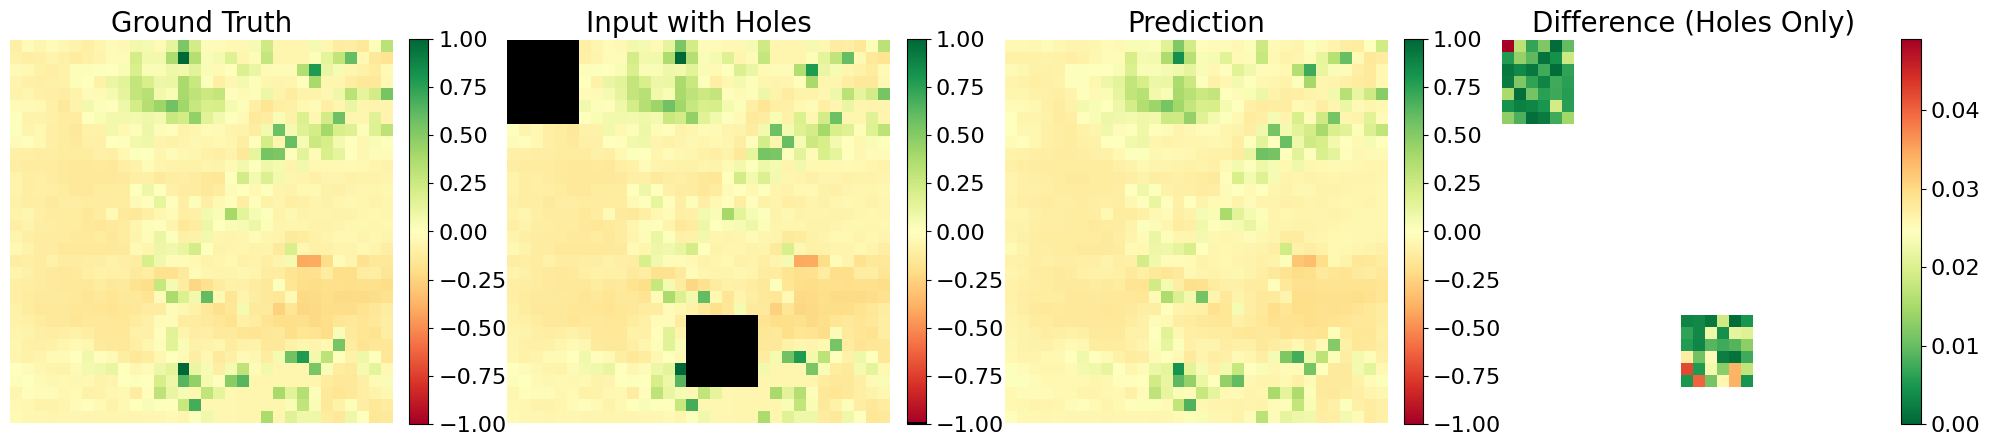

In [ ]:
# Creation of a custom colormap for holes (special values = 10)
cmap = plt.cm.RdYlGn  # Base colormap
cmap_colors = cmap(np.linspace(0, 1, 256))
cmap_colors[0] = [0, 0, 0, 1]  # Black for holes (values of 10)
custom_cmap = ListedColormap(cmap_colors)

# Custom normalization
class CustomNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, special_value=None, **kwargs):
        super().__init__(vmin=vmin, vmax=vmax, **kwargs)
        self.special_value = special_value

    def __call__(self, value, clip=None):
        # Treat holes as a special value
        result = super().__call__(value, clip)
        result = np.ma.masked_where(value == self.special_value, result)
        result = np.ma.filled(result, 0)  # Map holes (values of 10) to the first color (black)
        return result

# Apply custom normalization to handle holes
norm = CustomNormalize(vmin=-1, vmax=1, special_value=10)

# Calculate the difference between the predicted image and the original image
difference = np.abs(X_test - y_pred.squeeze())  # Absolute difference

# Create a mask to display only the holes
mask_holes = (y_test == 10)  # Mask of holed pixels
difference_holes_only = np.where(mask_holes, difference, np.nan)  # Mask other pixels

# Visualization of results
idx = 2401  # Index to visualize a specific sample

plt.figure(figsize=(20, 5))

# Ground truth
plt.subplot(1, 4, 1)
plt.title("Ground Truth", fontsize=20)  # Increase font size
img1 = plt.imshow(X_test[idx, :, :], cmap='RdYlGn', norm=norm)
plt.axis('off')
cbar1 = plt.colorbar(img1, fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Input image with holes
plt.subplot(1, 4, 2)
plt.title("Input with Holes", fontsize=20)  # Increase font size
img2 = plt.imshow(y_test[idx, :, :], cmap=custom_cmap, norm=norm)
plt.axis('off')
cbar2 = plt.colorbar(img2, fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Predictions
plt.subplot(1, 4, 3)
plt.title("Prediction", fontsize=20)  # Increase font size
img3 = plt.imshow(y_pred[idx, :, :], cmap='RdYlGn', norm=norm)
plt.axis('off')
cbar3 = plt.colorbar(img3, fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Difference only in the holes
plt.subplot(1, 4, 4)
plt.title("Difference (Holes Only)", fontsize=20)  # Increase font size
img4 = plt.imshow(difference_holes_only[idx, :, :], cmap='RdYlGn_r', vmin=0)  # Colormap for differences
plt.axis('off')
cbar4 = plt.colorbar(img4, fraction=0.046, pad=0.04)
cbar4.ax.tick_params(labelsize=16)  # Increase colorbar font size

plt.tight_layout()
plt.show()


The next cells are used to test the model.

In [ ]:
MASK_VALUE = 10  # Replace with your actual mask value

# Flatten the arrays to simplify processing
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Step 1: Create a mask for valid pixels
valid_mask = y_test_flat != MASK_VALUE

# Step 2: Extract valid pixels from ground truth and predictions
y_test_valid = y_test_flat[valid_mask]
y_pred_valid = y_pred_flat[valid_mask]

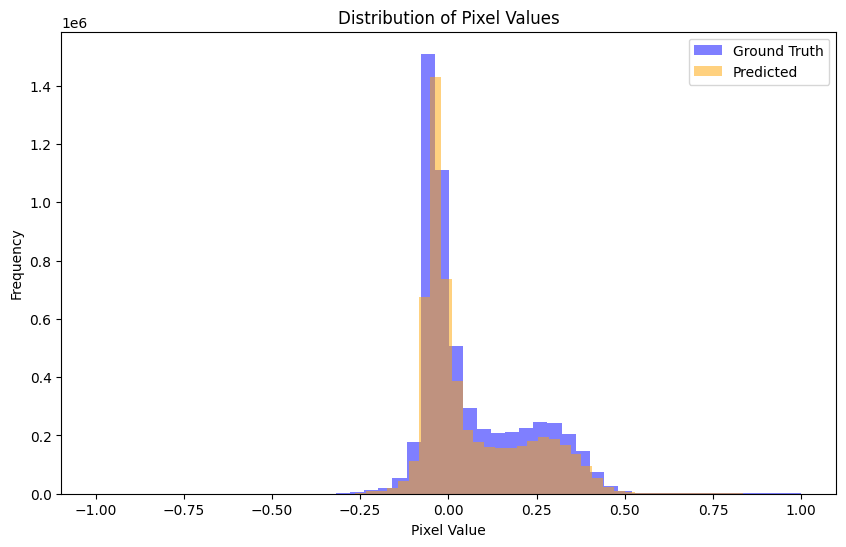

<ipython-input-68-09dce2b95e20>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test_valid, label='Ground Truth', color='blue', shade=True)
<ipython-input-68-09dce2b95e20>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_valid, label='Predicted', color='orange', shade=True)


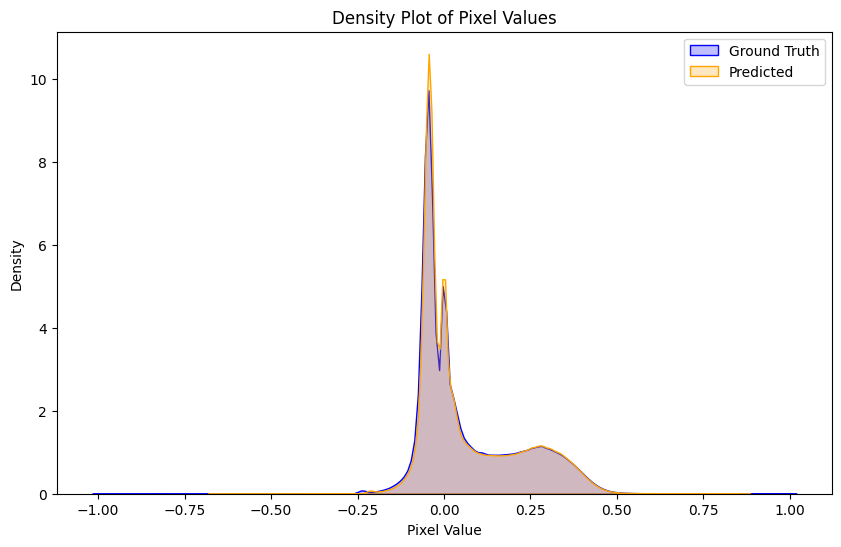

In [ ]:
# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(y_test_valid, bins=50, alpha=0.5, label='Ground Truth', color='blue')
plt.hist(y_pred_valid, bins=50, alpha=0.5, label='Predicted', color='orange')
plt.title('Distribution of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Density plot (smoother)
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test_valid, label='Ground Truth', color='blue', shade=True)
sns.kdeplot(y_pred_valid, label='Predicted', color='orange', shade=True)
plt.title('Density Plot of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
#Evaluation metrics
mae = np.mean(np.abs(y_test_valid - y_pred_valid))
print(f"Mean Absolute Error (MAE): {mae}")
rmse = np.sqrt(np.mean((y_test_valid - y_pred_valid) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse}")
mape = np.mean(np.abs((y_test_valid - y_pred_valid) / y_test_valid)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
correlation = np.corrcoef(y_test_valid, y_pred_valid)[0, 1]
r_squared = correlation ** 2
print(f"R² (Coefficient of Determination): {r_squared}")


Mean Absolute Error (MAE): 0.00452312221750617
Root Mean Square Error (RMSE): 0.008615781553089619
Mean Absolute Percentage Error (MAPE): inf%
R² (Coefficient of Determination): 0.9970497070570916


<ipython-input-69-f0cdbcfc372e>:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_valid - y_pred_valid) / y_test_valid)) * 100


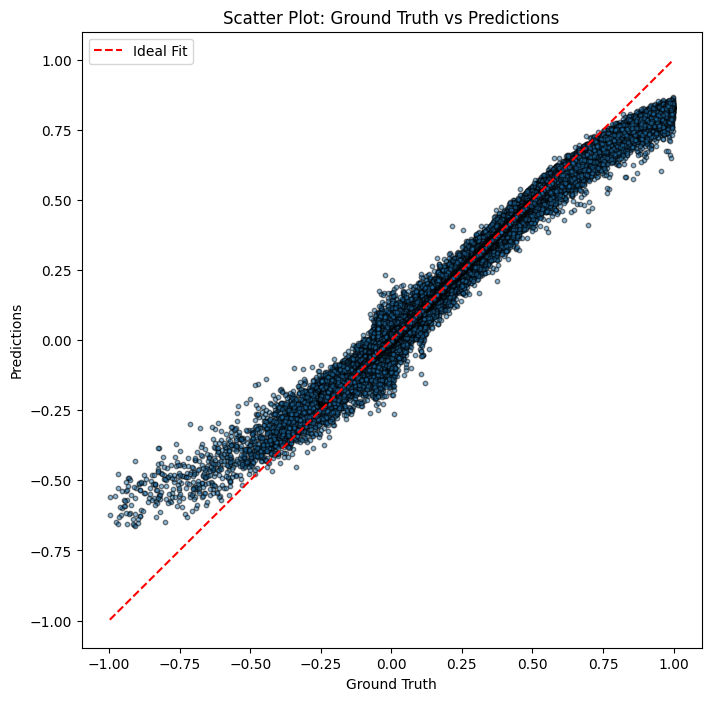

In [ ]:
#Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_valid, y_pred_valid, alpha=0.5, edgecolor='k', s=10)
plt.plot([y_test_valid.min(), y_test_valid.max()],
         [y_test_valid.min(), y_test_valid.max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title('Scatter Plot: Ground Truth vs Predictions')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.legend()
plt.show()


#### 4. Other

This section contains elements used to create figure for the report.

In [ ]:
model_path = '/content/drive/My Drive/NDVI_images/best_unet_model_4.keras'
model = load_model(model_path, custom_objects={'masked_mae': masked_mae})

# Print the model architecture
model.summary()

In [ ]:
# Create the Graphviz object
graph = pydot.Dot(graph_type='digraph', rankdir='TB')  # 'TB' for Top to Bottom layout

# Define the layers and their properties
layers = [
    ("Input", "Input Layer", None),
    ("Conv1", "Conv2D (64 filters, 3x3)", 'relu'),
    ("Conv2", "Conv2D (64 filters, 3x3)", 'relu'),
    ("Dropout1", "Dropout (0.2)", None),
    ("Pool1", "MaxPooling2D (2x2)", None),
    ("Conv3", "Conv2D (128 filters, 3x3)", 'relu'),
    ("Conv4", "Conv2D (128 filters, 3x3)", 'relu'),
    ("Dropout2", "Dropout (0.3)", None),
    ("UpSample", "UpSampling2D (2x2)", None),
    ("Concat", "Concatenate (Skip Connection)", None),
    ("Conv5", "Conv2D (64 filters, 3x3)", 'relu'),
    ("Conv6", "Conv2D (64 filters, 3x3)", 'relu'),
    ("Output", "Conv2D (1 filter, 1x1)", 'tanh')
]

# Create nodes for the layers
for layer, label, activation in layers:
    label_text = f"{label}\nActivation: {activation}" if activation else label
    graph.add_node(pydot.Node(layer, label=label_text))

# Add edges (connections) between layers
graph.add_edge(pydot.Edge("Input", "Conv1"))
graph.add_edge(pydot.Edge("Conv1", "Conv2"))
graph.add_edge(pydot.Edge("Conv2", "Dropout1"))
graph.add_edge(pydot.Edge("Dropout1", "Pool1"))
graph.add_edge(pydot.Edge("Pool1", "Conv3"))
graph.add_edge(pydot.Edge("Conv3", "Conv4"))
graph.add_edge(pydot.Edge("Conv4", "Dropout2"))
graph.add_edge(pydot.Edge("Dropout2", "UpSample"))
graph.add_edge(pydot.Edge("UpSample", "Concat"))
graph.add_edge(pydot.Edge("Concat", "Conv5"))
graph.add_edge(pydot.Edge("Conv5", "Conv6"))
graph.add_edge(pydot.Edge("Conv6", "Output"))
graph.add_edge(pydot.Edge("Conv2", "Concat", style="dashed"))  # Dashed edge for the skip connection

# Render the diagram
os.environ["PATH"] += os.pathsep + '/usr/bin/dot'

# Save as a PNG file
graph.write_png('/content/drive/My Drive/NDVI_images/unet_structure_updated.png')